In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile
import re
import cv2
import random

from image_handler import get_bb_list, visualize, get_sample
import matplotlib.pyplot as plt

616
[[1, 121, 18, 142], [27, 112, 45, 131], [68, 112, 87, 131], [107, 106, 124, 123], [131, 109, 149, 131], [185, 115, 203, 135], [197, 103, 208, 126], [241, 111, 251, 124], [267, 76, 288, 101], [337, 83, 361, 107], [394, 92, 401, 111], [362, 90, 381, 111], [249, 110, 263, 129], [154, 122, 171, 142], [95, 115, 114, 137]] ['with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask'] [0.0033427  0.00320225 0.00338015 0.00270599 0.00370787 0.00337079
 0.00236891 0.00121723 0.00491573 0.00539326 0.00124532 0.00373596
 0.00249064 0.00318352 0.00391386]


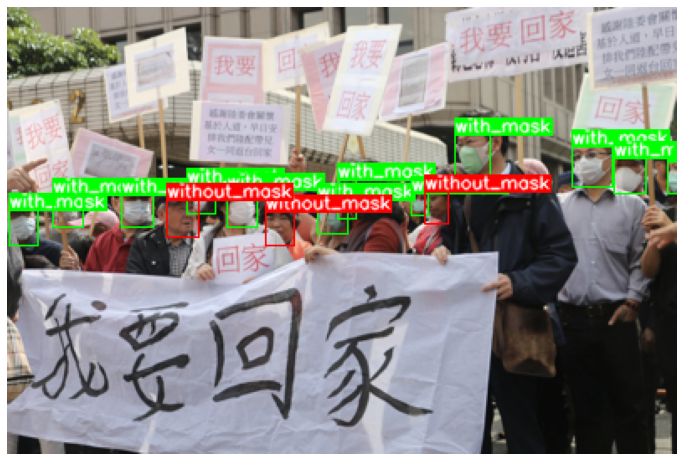

318
[[315, 59, 337, 88], [212, 52, 240, 80], [136, 59, 159, 86], [50, 82, 66, 99], [96, 55, 107, 71], [32, 61, 47, 76], [172, 77, 184, 89]] ['with_mask', 'with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask'] [0.00705752 0.00867257 0.00686947 0.00300885 0.0019469  0.00248894
 0.00159292]


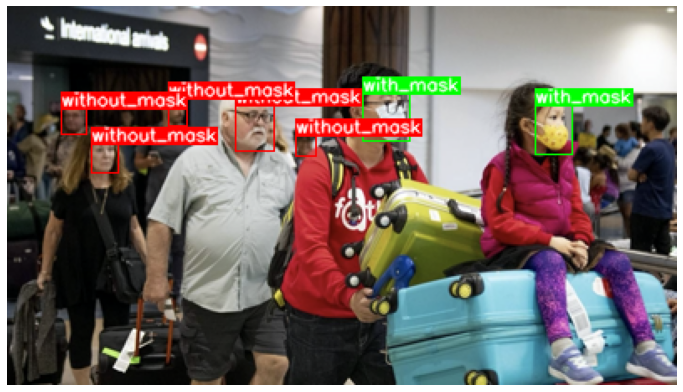

241
[[172, 74, 246, 147]] ['with_mask'] [0.06430952]


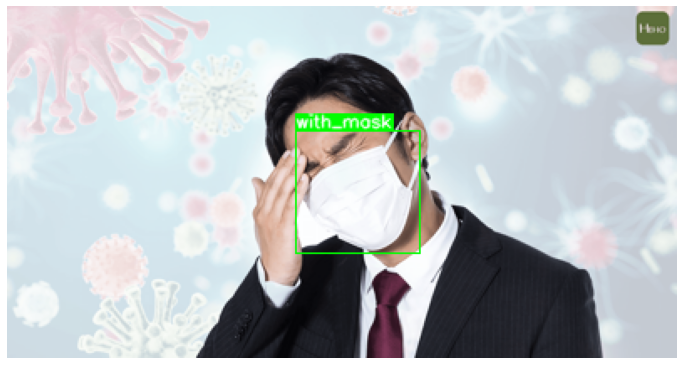

133
[[100, 179, 221, 318]] ['with_mask'] [0.13969269]


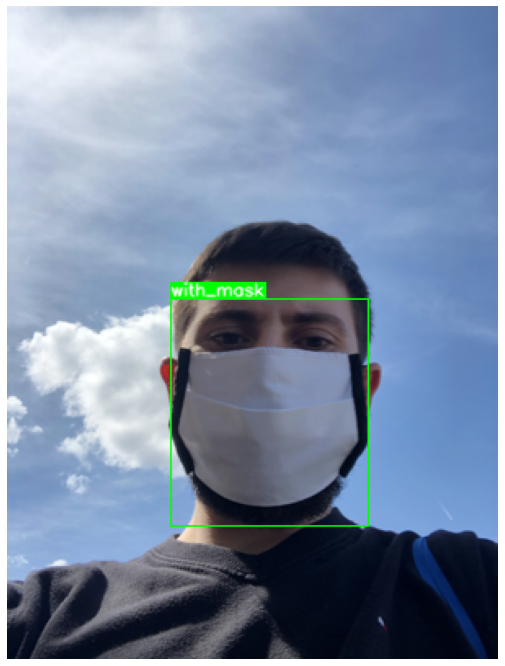

455
[[115, 222, 225, 373]] ['without_mask'] [0.13795681]


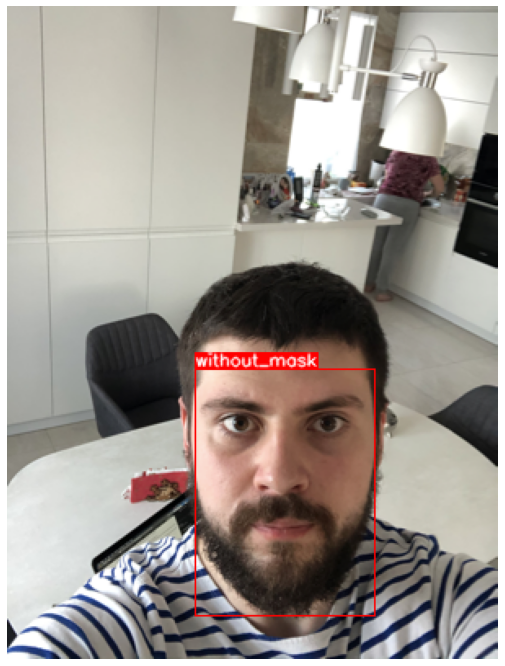

In [40]:
for i in range(5):
    r = random.randint(0,852)
    print(r)
    get_sample(n=r, info=True)

[[121, 47, 158, 80]] ['mask_weared_incorrect'] [0.01143258]


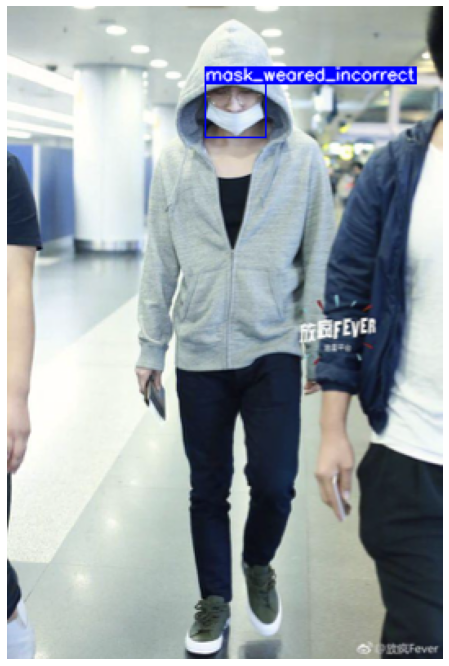

In [39]:
get_sample(658, info=True)

In [12]:
img_path = 'data/images'
ann_path = 'data/annotations'
targets = ['without_mask', 'mask_weared_incorrect', 'with_mask']

In [13]:
data = pd.DataFrame(columns=['idx', 'width', 'height', 'without_mask', 'incorrect_weared', 'with_mask'])
bboxes_area = []

In [14]:
count = 0
for file in listdir(ann_path):
    count += 1
    if isfile(ann_path+'/'+file):
        tree = ET.parse(ann_path+'/'+file)
        root = tree.getroot()
        without_mask, incorrect_weared, with_mask= 0, 0, 0
        idx = int(re.sub("[^0-9]", "", file))
        for child in root.findall('size'):
            w = child.find('width').text
            h = child.find('height').text
        
        img_area = int(w)*int(h)
        for child in root.findall('object'):
            t = child.find('name').text
            if t == targets[0]:
                without_mask += 1
            elif t == targets[1]:
                incorrect_weared += 1
            elif t == targets[2]:
                with_mask += 1
            else:
                print('Wrong value')
        
            for bb in child.findall('bndbox'):
                xmin = int(bb.find('xmin').text)
                ymin = int(bb.find('ymin').text)
                xmax = int(bb.find('xmax').text) 
                ymax = int(bb.find('ymax').text)

                bb_area = (ymax - ymin) * (xmax - xmin)
                bboxes_area.append(bb_area/img_area)
        
        df = {'idx': idx, 'width': w, 'height': h, 'without_mask': without_mask,
                           'incorrect_weared': incorrect_weared, 'with_mask': with_mask}
        data = data.append(df, ignore_index=True)
        
#         if count == 5:
#             break

print(data)
bboxes_area = np.array(bboxes_area)


     idx width height without_mask incorrect_weared with_mask
0      0   512    366            2                0         1
1      1   400    156            1                0         8
2     10   301    400            0                0         1
3    100   400    226            0                0         3
4    101   301    400            0                0         1
..   ...   ...    ...          ...              ...       ...
848   95   301    400            1                0         0
849   96   400    280            2                0         2
850   97   301    400            0                0         1
851   98   400    267            0                0         4
852   99   400    267            0                1         2

[853 rows x 6 columns]


In [15]:
data.sort_values('idx', inplace=True)
data.set_index('idx', inplace=True)

In [16]:
data.head(10)

,width,height,without_mask,incorrect_weared,with_mask
idx,,,,,
0,512,366,2,0,1
1,400,156,1,0,8
2,400,290,0,1,3
3,400,271,0,0,9
4,301,400,0,0,1
5,400,266,2,0,2
6,600,405,0,0,1
7,400,300,1,0,3
8,301,400,0,0,1


Баланс классов:

В маске: 0.79
Без маски: 0.18
Неправильно надета: 0.03


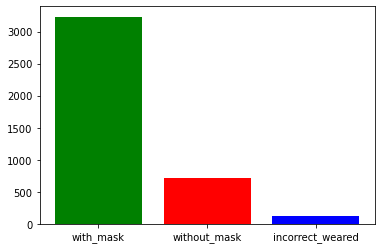

In [17]:
data['total_obj'] = data['without_mask'] + data['incorrect_weared'] + data['with_mask']
total_objects = data['total_obj'].sum()
print('В маске: {:.2f}\nБез маски: {:.2f}\nНеправильно надета: {:.2f}'.format(data['with_mask'].sum()/total_objects, data['without_mask'].sum()/total_objects,
                                                                              data['incorrect_weared'].sum()/total_objects))

index = ['with_mask','without_mask', 'incorrect_weared']
values = [data['with_mask'].sum(), data['without_mask'].sum(), data['incorrect_weared'].sum()]
plt.bar(index,values, color=['g', 'r', 'b'])
plt.show()

Small_size: 0.10
Medium_size 0.58
Big_size: 0.32


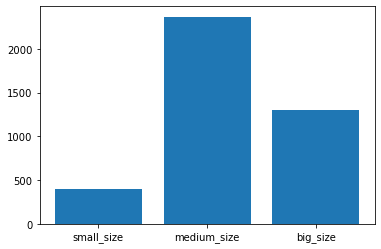

In [34]:
print('Small_size: {:.2f}\nMedium_size {:.2f}\nBig_size: {:.2f}'.format(np.count_nonzero(bboxes_area<0.001)/total_objects,
                                                                       (np.count_nonzero(bboxes_area>=0.001) - np.count_nonzero(bboxes_area>=0.01))/total_objects,
                                                                              np.count_nonzero(bboxes_area>=0.01)/total_objects))

index = ['small_size','medium_size', 'big_size']
values = [np.count_nonzero(bboxes_area<0.001), (np.count_nonzero(bboxes_area>=0.001) - np.count_nonzero(bboxes_area>=0.01)),
          np.count_nonzero(bboxes_area>=0.01)]
plt.bar(index,values)
plt.show()

In [33]:
pd.DataFrame({'bb': bboxes_area}).describe()

,bb
count,4072.000000
mean,0.017064
std,0.033748
min,0.000022
25%,0.002247
50%,0.005133
75%,0.013526
max,0.427316
